In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [49]:
import seaborn as sns

In [50]:
sns.set_context('paper', font_scale=2.2)
sns.set_style('ticks')

In [51]:
import LB_colony_growth.LB_colony_growth as lb

import skimage as ski
import skimage.draw

In [52]:
dimension = 2

workgroup_x = 32
workgroup_y = 16

halo = 1 #ALWAYS 1 for this system.

num_alleles = 2

nx = 128
ny = 128

velocity_set = 'D2Q9'

In [53]:
ctx_info = {}
ctx_info['num_type'] = 'double'

ctx_info['nx'] = nx
ctx_info['ny'] = ny
ctx_info['nz'] = None

ctx_info['local_size'] = (workgroup_x, workgroup_y)
ctx_info['domain_size'] = (nx, ny)

ctx_info['dimension'] = dimension
ctx_info['num_alleles'] = num_alleles

ctx_info['kernel_arguments'] = {}

In [54]:
bc_map = np.zeros((nx + 2*halo, ny + 2*halo), dtype=lb.int_type)

bc_map[...] = lb.FLUID_NODE

bc_map[0:halo, :] = lb.WALL_NODE
bc_map[-halo:, :] = lb.WALL_NODE
bc_map[:, 0:halo] = lb.WALL_NODE
bc_map[:, -halo:] = lb.WALL_NODE

In [55]:
R0 = 10

[r, c] = ski.draw.circle(nx/2, ny/2, R0)

rand_alleles = np.random.randint(-num_alleles, 0, size=(nx, ny))

In [56]:
bc_map[r, c] = rand_alleles[r, c]

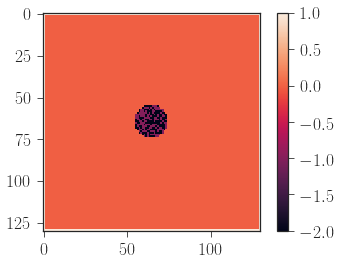

In [57]:
plt.imshow(bc_map)
plt.colorbar()

In [58]:
# Initialize rho...one everywhere, except in the circle where cells were inoculated

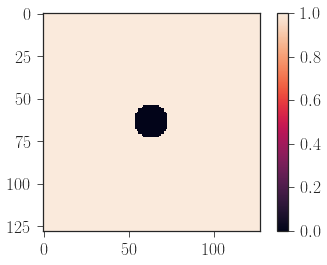

In [59]:
rho = np.ones((nx, ny), dtype=lb.num_type)
bc_in_domain = bc_map[halo:-halo, halo:-halo]

rho[bc_in_domain < 0] = 0

plt.imshow(rho)
plt.colorbar()

In [60]:
m0 = 1.0

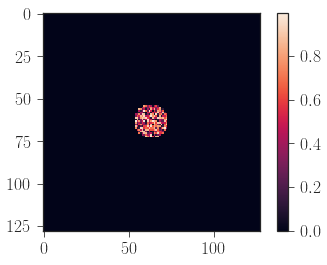

In [61]:
# Initialize the current amount of absorbed mass randomly

absorbed_mass = np.random.rand(nx, ny)
bc_in_domain = bc_map[halo:-halo, halo:-halo]

absorbed_mass[bc_in_domain >= 0] = 0

plt.imshow(absorbed_mass)
plt.colorbar()

In [62]:
k_list = [.1, .1]
m_reproduce_list = [m0, m0]
velocity_set = 'D2Q9'
D = .5 * (1./3.)

In [63]:
dla_colony = lb.DLA_Colony(
    ctx_info=ctx_info, velocity_set='D2Q9',
    bc_map=bc_map, 
    D=D, k_list=k_list, m_reproduce_list=m_reproduce_list,
    absorbed_mass=absorbed_mass, rho=rho)

global size: (128, 128)
local size: (32, 16)
The platforms detected are:
---------------------------
Intel(R) OpenCL Intel(R) Corporation version: OpenCL 1.2 LINUX
The devices detected on platform Intel(R) OpenCL are:
---------------------------
       Intel(R) Core(TM) i7-3537U CPU @ 2.00GHz [Type: CPU ]
Maximum clock Frequency: 2000 MHz
Maximum allocable memory size: 2062 MB
Maximum work group size 8192
Maximum work item dimensions 3
Maximum work item size [8192L, 8192L, 8192L]
---------------------------
This context is associated with  1 devices
tau 1.0
omega 1.0
global_size_bc: (160, 144)
Connecting python to the opencl_kernel init_feq...
Connecting python to the opencl_kernel collide_and_propagate...
Creating local memory of double type...
Creating local memory of int type...
Connecting python to the opencl_kernel update_after_streaming...
Connecting python to the opencl_kernel reproduce...
Creating local memory of int type...
Connecting python to the opencl_kernel copy_streamed_

LB_colony_growth/LB_colony_growth.py:456: UserWarning: Received OpenCL source code in Unicode, should be ASCII string. Attempting conversion.
  self.kernels = cl.Program(self.context, buf.getvalue()).build(options='')
/home/bryan/anaconda2/lib/python2.7/site-packages/pyopencl/cffi_cl.py:1516: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) Core(TM) i7-3537U CPU @ 2.00GHz' on 'Intel(R) OpenCL' at 0x7fc9ca751588> succeeded, but said:

Compilation started
Compilation done
Linking started
Linking done
Device build started
Device build done
Kernel <collide_and_propagate> was successfully vectorized (4)
Kernel <update_after_streaming> was successfully vectorized (4)
Kernel <init_feq> was successfully vectorized (4)
Kernel <reproduce> was not vectorized
Kernel <copy_streamed_onto_f> was successfully vectorized (4)
Done.
  warn(text, CompilerWarning)


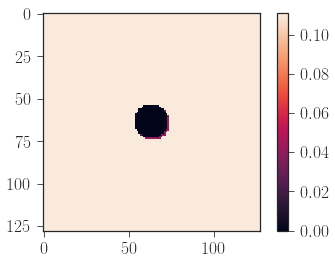

In [104]:
plt.imshow(dla_colony.f_streamed.get()[:, :, 3])
plt.colorbar()

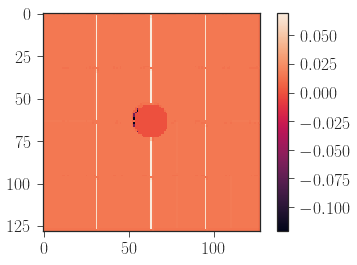

In [103]:
plt.imshow(dla_colony.f.get()[:, :, 0])
plt.colorbar()

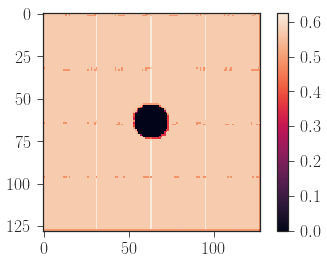

In [110]:
plt.imshow(dla_colony.rho.get(), interpolation=None)
plt.colorbar()

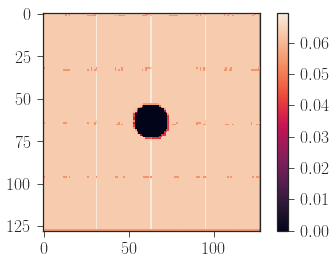

In [101]:
plt.imshow(dla_colony.feq.get()[:, :, 3])
plt.colorbar()

In [100]:
dla_colony.run(150)

In [117]:
dla_colony.feq.get().sum()

9163.1846361312855

In [118]:
dla_colony.rho.get().sum()

9163.184636131291

In [119]:
dla_colony.f.get().sum()

9163.1846361312892

In [120]:
dla_colony.f_streamed.get().sum()

9163.1846361312892

In [80]:
# dla_colony.collide_and_propagate.run().wait()
# dla_colony.copy_streamed_onto_f.run().wait()

In [115]:
dla_colony.update_after_streaming.run().wait()

Weird stripes appear to be appearing in my solutions, IDK what's up with that. We will have to troubleshoot...

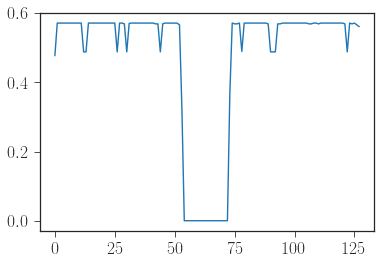

In [122]:
plt.plot(dla_colony.rho.get()[nx/2, :])

lol yeah wtf is going on

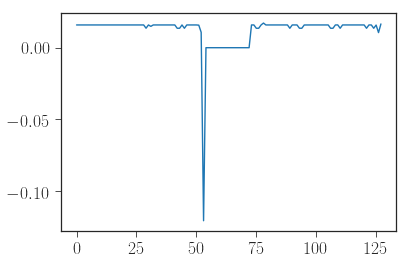

In [134]:
plt.plot(dla_colony.f.get()[nx/2, :, 0])